In [18]:
import torch
import torch.nn as nn
import numpy as np
import math


#Y_tau = sigma * torch.randn(64,64)
#print(Y_tau)

def gauss_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size):
    Y_tau = Y_0
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau / sigma / sigma) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
    Y_tau = Y_0
    omegat = range(image_size * image_size) 
    omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
    beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
    #beta_omega = [xx ** beta / image_size / image_size for xx in omega]
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (sum(beta_omega) * Y_tau / sigma / sigma) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

(array([5.38988391e+00, 7.02697303e+00, 1.90472631e+00, 6.16736617e-01,
        4.73239572e-01, 2.06354143e-01, 1.90034136e-01, 1.58603562e-01,
        5.48048578e-02, 1.97232260e-02, 1.45176290e-02, 1.25861649e-02,
        4.48476009e-02, 8.25724556e-02, 1.07315752e-01, 1.35842532e-01,
        1.72123019e-01, 1.57238661e-01, 1.09661567e-01, 4.92080083e-02,
        2.45082009e-03, 1.06489552e-02, 2.39863359e-02, 1.99804088e-02,
        1.98376913e-02, 3.49548471e-02, 4.08702598e-02, 4.48089911e-02,
        8.83623651e-02, 8.66128516e-02, 2.05510554e-02, 8.37972484e-03,
        4.34320434e-02, 8.86664774e-02, 1.14927896e-01, 6.73916269e-02,
        1.46043778e-02, 3.34578166e-03, 2.51513116e-03, 2.36484546e-02,
        3.94821185e-02, 2.13059619e-02, 5.81996123e-03, 7.81918725e-03,
        1.30572153e-02, 1.65745768e-02, 1.78653787e-02, 1.70952863e-02,
        1.07046258e-02, 4.19393233e-03, 4.15192733e-02, 1.11174697e-01,
        1.29644605e-01, 8.60861225e-02, 3.17492046e-02, 8.855578

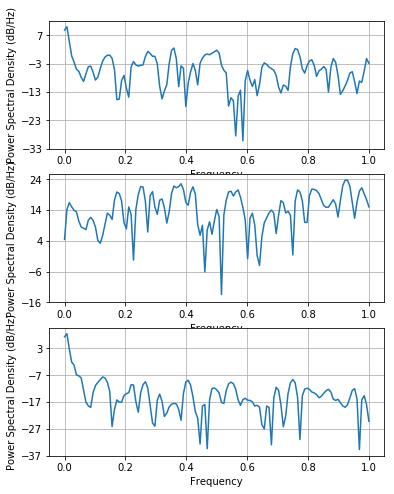

In [31]:
import pylab as plt
langevin_step_size = 0.01
sigma = 0.1  
langevin_step_num = 10000
beta = 0.1
image_size = 128
Y_0 = sigma * torch.randn(image_size,image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)


Y_out = gauss_omega_mcmc_simulate(Y_u0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta)
#print(Y_out)


plt.figure(figsize=(6,8))
plt.subplot(311)
plt.psd(Y_out)
#plt.subplot(212)
plt.subplot(312)
plt.psd(Y_0)
plt.subplot(313)
plt.psd(Y_u0)

(array([3.68946147e-07, 7.20755643e-07, 6.71732590e-07, 5.97491892e-07,
        5.07633810e-07, 4.12821139e-07, 3.22847301e-07, 2.45084478e-07,
        1.83623574e-07, 1.39213433e-07, 1.09894032e-07, 9.20590812e-08,
        8.16177439e-08, 7.49598016e-08, 6.95390771e-08, 6.40312665e-08,
        5.81468093e-08, 5.22523278e-08, 4.69636127e-08, 4.28304122e-08,
        4.01650281e-08, 3.90027763e-08, 3.91443345e-08, 4.02247557e-08,
        4.17738195e-08, 4.32610984e-08, 4.41400934e-08, 4.39094741e-08,
        4.21964520e-08, 3.88467418e-08, 3.39898145e-08, 2.80467219e-08,
        2.16629312e-08, 1.55745991e-08, 1.04426062e-08, 6.70332964e-09,
        4.48205566e-09, 3.59491304e-09, 3.63581920e-09, 4.11726322e-09,
        4.61788077e-09, 4.89090929e-09, 4.90435036e-09, 4.80897437e-09,
        4.85454338e-09, 5.28935041e-09, 6.27911690e-09, 7.86955566e-09,
        9.99802831e-09, 1.25412141e-08, 1.53741359e-08, 1.84146549e-08,
        2.16360037e-08, 2.50440871e-08, 2.86305418e-08, 3.232185

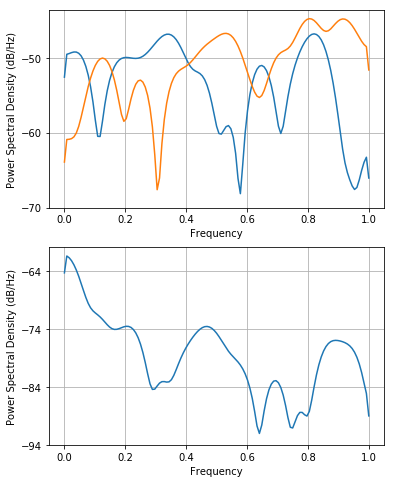

In [3]:
import pylab as plt
langevin_step_size = 0.01
sigma = 0.1  
langevin_step_num = 100
image_size = 32
Y_0 = sigma * torch.randn(image_size,image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)


Y_out = gauss_mcmc_simulate(Y_u0 ,langevin_step_size ,langevin_step_num ,sigma, image_size)
#print(Y_out)


plt.figure(figsize=(6,8))
plt.subplot(211)
plt.psd(Y_0)
#plt.subplot(212)
plt.psd(Y_out)
plt.subplot(212)
plt.psd(Y_u0)

In [26]:
import math
image_size =4
omegat = range(image_size * image_size) 
omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
beta = 0.1
beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
print(omega)
print(sum(beta_omega))
print(1/max(beta_omega))


[-1.5707963267948966, -1.3744467859455345, -1.1780972450961724, -0.9817477042468103, -0.7853981633974483, -0.5890486225480862, -0.39269908169872414, -0.19634954084936207, 0.0, 0.19634954084936207, 0.39269908169872414, 0.5890486225480862, 0.7853981633974483, 0.9817477042468103, 1.1780972450961724, 1.3744467859455345]
0.9069024508903286
15.293539001264099
